In [226]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import codes.data_utils
import importlib

importlib.reload(codes.data_utils)
from codes.data_utils import set_seed

import importlib
import codes.models.custom_gcrn

importlib.reload(codes.models.custom_gcrn)

from codes.models.custom_gcrn import GCRN

import codes.models.custom_gcn_transformer_parallel

importlib.reload(codes.models.custom_gcn_transformer_parallel)

from codes.models.custom_gcn_transformer_parallel import SpatioTemporalFusionNet


set_seed(42)
# Load centrality data
centrality_df = pd.read_excel("data/Centrality_indices.xlsx")

In [227]:
clean_cities_df = centrality_df
clean_city_ids = set(clean_cities_df['Codmundv'].astype(int).unique())

In [228]:
pop_df = pd.read_csv("data/cleaned_population_2022.csv")
scaler = MinMaxScaler()
pop_df_filtered = pop_df[pop_df["ibgeID"].isin(clean_city_ids)].copy()
top_240_pop_cities = set(pop_df_filtered.sort_values(by="population", ascending=False)["ibgeID"].head(40).tolist())
pop_df_filtered["Population_2025_Normalized"] = scaler.fit_transform(pop_df_filtered[["population"]])

In [229]:
import codes.extract_backbone

importlib.reload(codes.extract_backbone)
from codes.extract_backbone import extract_backbone_from_files_brazil

backbone_df, backbone_cities = extract_backbone_from_files_brazil(
    centrality_path="data/Centrality_indices.xlsx",
    mobility_edges_path="data/Road_and_waterway_connections_database_2016.xlsx",
    alpha=0.01,
    city_whitelist=top_240_pop_cities
)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df[['source', 'target', 'weekly_flow', 'pij']].head())

[✓] Backbone extracted and saved to 'data/mobility_backbone_brazil.csv'.
Backbone extracted with 142 edges
       source   target  weekly_flow  pij
190   1302603  1501402          3.5  0.0
250   3170206  5201405          0.0  1.0
321   2910800  3550308          0.0  1.0
1073  2304400  3509502          0.0  1.0
1666  2211001  3509502          0.0  1.0


In [230]:
pop_df_filtered = pop_df_filtered[pop_df_filtered["ibgeID"].isin(backbone_cities)]

In [231]:
from codes.graph_utils import build_pyg_graph_from_backbone

pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city, 0.0) for city in backbone_cities]

centrality_df = centrality_df[centrality_df['Codmundv'].isin(backbone_cities)].copy()
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)
pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)
print(pyg_data)

[✓] Graph built with 38 nodes and 142 edges.
[✓] Converted to PyTorch Geometric format.
Data(edge_index=[2, 284], name=[38], weight=[284], edge_attr=[284, 1], num_nodes=38, x=[38, 1])


In [232]:
import numpy as np
from codes.load_and_save_covid_data import load_and_save_covid_data

covid_df = load_and_save_covid_data()
covid_df = covid_df[covid_df["ibgeID"].isin(backbone_cities)]

print(f"Full date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Total records: {len(covid_df):,}")

negative_counts = (covid_df.select_dtypes(include=[np.number]) < 0).sum()
print("📉 Negative values per column:")
print(negative_counts[negative_counts > 0])


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Full date range: 2020-02-25 00:00:00 to 2023-03-18 00:00:00
Total records: 41,747
📉 Negative values per column:
newDeaths    558
newCases     516
dtype: int64


In [233]:
import codes.preprocess_covid_brazil
importlib.reload(codes.preprocess_covid_brazil)
from codes.preprocess_covid_brazil import filter_and_scale_covid_by_centrality

filtered_scaled_covid_df = filter_and_scale_covid_by_centrality(covid_df, city_whitelist=backbone_cities)

[✓] Filtered to 38 cities, 41,747 rows.
[✓] Negative values in 'newCases' and 'newDeaths' clipped to 0.
[✓] Computed cases and deaths per 100,000 population.
[✓] Applied Z-score normalization.
[✓] Saved filtered + scaled COVID data to 'data/filtered_scaled_covid.csv'.


In [234]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [235]:
from codes.data_utils import prepare_temporal_graph_data_non_overlapping, generate_sliding_temporal_graph_data, \
    prepare_temporal_graph_data_non_overlapping

# Traditional (non-sliding) approach
X_train_static, X_test_static, Y_train_static, Y_test_static = prepare_temporal_graph_data_non_overlapping(
    filtered_scaled_covid_df,
    sequence_length=15,
    feature_column="z_newCases",
    device=device
)

# Sliding window approach
X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    filtered_scaled_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device
)

Y_train_slide = Y_train_slide.squeeze(1)
print(Y_train_slide.shape)

Y_test_slide = Y_test_slide.squeeze(1)
print(Y_test_slide.shape)

# Compare number of samples
total_static = len(X_train_static) + len(X_test_static)
total_slide = len(X_train_slide) + len(X_test_slide)

print("📊 Sample Count Comparison")
print(f"Static window (15 input, 1 output): {total_static} samples")
print(f"Sliding window (10 input, 1 output): {total_slide} samples")
print(f"⬆️ Gain: {total_slide - total_static} samples (+{100 * (total_slide - total_static) / total_static:.2f}%)")

X_train_slide_for_global, X_test_slide_for_global, Y_train_slide_for_global, Y_test_slide_for_global = generate_sliding_temporal_graph_data(
    filtered_scaled_covid_df,
    input_window=7,
    output_window=1,
    feature_column="z_newCases",
    device=device
)

[📉] (Non-overlapping) X shape: torch.Size([69, 15, 38, 1]) | Y shape: torch.Size([69, 38, 1])
[📉] Train: torch.Size([55, 15, 38, 1]) | Test: torch.Size([14, 15, 38, 1])
[✓] Sliding window: X torch.Size([1104, 14, 38, 1]), Y torch.Size([1104, 1, 38, 1])
[✓] Train: torch.Size([883, 14, 38, 1]), Test: torch.Size([221, 14, 38, 1])
torch.Size([883, 38, 1])
torch.Size([221, 38, 1])
📊 Sample Count Comparison
Static window (15 input, 1 output): 69 samples
Sliding window (10 input, 1 output): 1104 samples
⬆️ Gain: 1035 samples (+1500.00%)
[✓] Sliding window: X torch.Size([1111, 7, 38, 1]), Y torch.Size([1111, 1, 38, 1])
[✓] Train: torch.Size([888, 7, 38, 1]), Test: torch.Size([223, 7, 38, 1])


In [236]:
N = len(backbone_cities)

In [237]:
model_gcrn = GCRN(in_channels=1, hidden_channels=64, out_channels=1).to(device)

state_dict = torch.load("models/Brazil-Experiment-Top-240-GCRN-Attempt-1.pth")
model_gcrn.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [238]:
model_local = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=1,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=64,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

state_dict = torch.load("models/Brazil-Experiment-Top-240-Local-Transformer-Attempt-2-Final.pth")
model_local.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [239]:
import codes.models.global_spatiotemporal_model
import torch.nn as nn

importlib.reload(codes.models.global_spatiotemporal_model)

from codes.models.global_spatiotemporal_model import SpatiotemporalTransformer

model = SpatiotemporalTransformer(
    input_dim=1,         # One feature per city per day: "newCases"
    gcn_dim=1,           # No static node features (population, centrality) passed
    hidden_dim=64,       # Transformer + GCN hidden size
    nhead=2,             # Number of transformer heads
    num_layers=1,        # Transformer layers
    num_nodes=N,         # Number of nodes in the graph
    forecast_dim=1       # Predict one value per node (1-day ahead cases)
).to(device) 

state_dict = torch.load("models/Brazil-Experiment-Cleaned-Global-Attempt-4-Final.pth")
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [240]:
criterion = nn.MSELoss()

In [241]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [242]:
batch_size = 8  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide_for_global, Y_train_slide_for_global)
test_dataset = CovidGraphDataset(X_test_slide_for_global, Y_test_slide_for_global)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [243]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [244]:
from tqdm import tqdm

test_dataset_gcrn = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader_gcrn = DataLoader(test_dataset_gcrn, batch_size=batch_size)

model_gcrn.eval()
test_loss = 0.0
predictions_gcrn = []
actuals_gcrn = []

with torch.no_grad():
    progress_bar = tqdm(test_loader_gcrn, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        output = model_gcrn(batch_X, edge_index, edge_weight)  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions_gcrn.append(output.cpu())     # [B, N, 1]
        actuals_gcrn.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions_gcrn = torch.cat(predictions_gcrn, dim=0)
actuals_gcrn = torch.cat(actuals_gcrn, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.6653


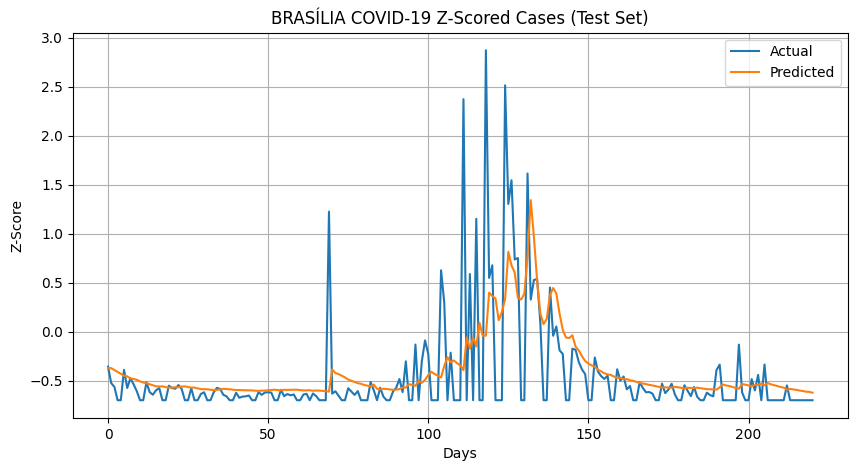

In [252]:
import matplotlib.pyplot as plt
import networkx as nx

G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions_gcrn.squeeze(-1).numpy()  # [T, N]
actual_array = actuals_gcrn.squeeze(-1).numpy()  # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)

sp_preds_gcrn = pred_array[:, sp_index]
sp_actuals_gcrn = actual_array[:, sp_index]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sp_actuals_gcrn, label='Actual')
plt.plot(sp_preds_gcrn, label='Predicted')
plt.title("BRASÍLIA COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

In [246]:
batch_size_nodes = 500
num_nodes = N 

In [249]:
test_dataset = CovidGraphDataset(X_test_slide_for_global, Y_test_slide_for_global)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1).to(device)

        output = model(batch_X, edge_index, edge_weight, node_features=pyg_data.x.to(device))  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.6701


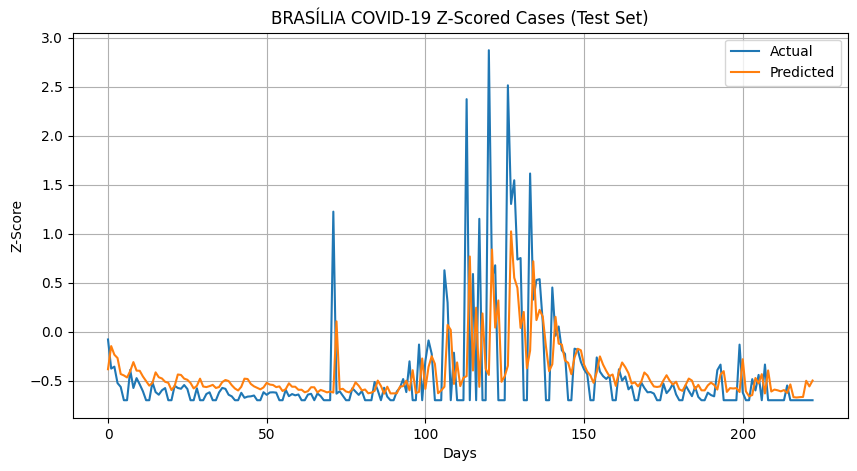

📉 RMSE for BRASÍLIA: 0.4941


In [250]:
import matplotlib.pyplot as plt
import networkx as nx

G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)

sp_preds = pred_array[:, sp_index]
sp_actuals = actual_array[:, sp_index]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual')
plt.plot(sp_preds, label='Predicted')
plt.title("BRASÍLIA COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()


from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for BRASÍLIA: {rmse_sp:.4f}")



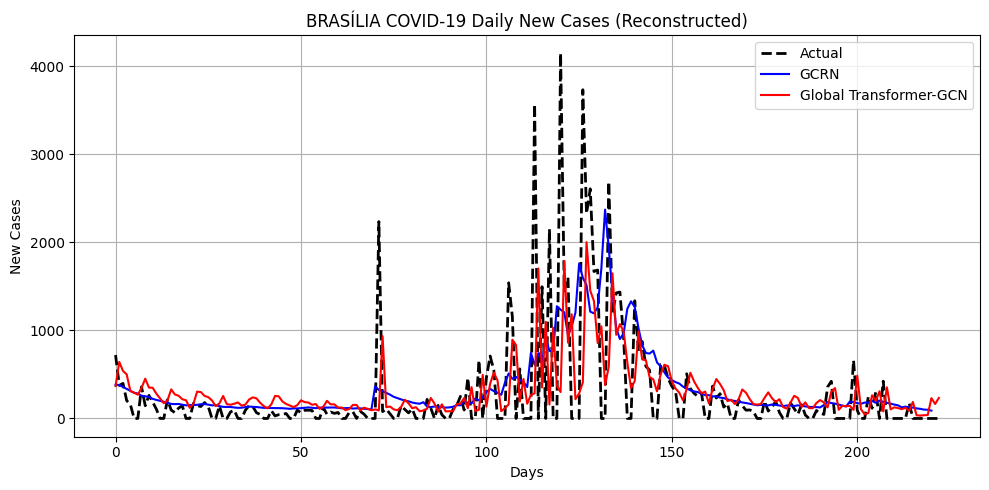

In [262]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Get index of Brasília
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)

# Collapse predictions: [T, N]
pred_array_global = predictions.squeeze(-1).numpy()
actual_array_global = actuals.squeeze(-1).numpy()
pred_array_gcrn = predictions_gcrn.squeeze(-1).numpy()
actual_array_gcrn = actuals_gcrn.squeeze(-1).numpy()

# Extract Z-scored predictions/actuals
sp_preds_global_z = pred_array_global[:, sp_index]
sp_preds_gcrn_z = pred_array_gcrn[:, sp_index]
sp_actuals_z = actual_array_global[:, sp_index]  # Same for both

# Reconstruct actual values using mean/std from original (unscaled) data
sp_original = covid_df[covid_df['ibgeID'] == sp_code].copy()
sp_original['newCases'] = sp_original['newCases'].clip(lower=0)
sp_original = sp_original.sort_values('date')

mean_sp = sp_original['newCases'].mean()
std_sp = sp_original['newCases'].std(ddof=0)

# Denormalize
sp_preds_global = sp_preds_global_z * std_sp + mean_sp
sp_preds_gcrn = sp_preds_gcrn_z * std_sp + mean_sp
sp_actuals = sp_actuals_z * std_sp + mean_sp

# 📊 Plot
plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual', color='black', linestyle='--', linewidth=2)
plt.plot(sp_preds_gcrn, label='GCRN', color='blue')
plt.plot(sp_preds_global, label='Global Transformer-GCN', color='red')

plt.title("BRASÍLIA COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/brasília_gcrn_vs_global_actual.png", dpi=300)
plt.show()